# Fast low-rank nonnegative tensor factorizations in tensor train format

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as spio
from time import time

from tensor_train import TensorTrain
from info import Info

In [3]:
%%bash
uname -m
sysctl -n machdep.cpu.brand_string
echo -n "CPU(s): " && sysctl -n hw.physicalcpu
echo -n "RAM:    " && sysctl -n hw.memsize | awk '{print $0/1073741824" GB"}'

x86_64
Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
CPU(s): 6
RAM:    16 GB


## 1 Hilbert

In [4]:
sizes = [60, 50, 50]
ranks = [1, 3, 2, 1]

a = np.empty(shape=sizes)

m, n, l = a.shape
for i in range(m):
    for j in range(n):
        for k in range(l):
            a[i, j, k] = 1 / ((i+1) + (j+1) + (k+1) - 3 + 1)

In [5]:
# after TTSVD

full = TensorTrain.GetFullTensor(TensorTrain.TTSVD(a, ranks))
print('relative error', np.linalg.norm(a - full) / np.linalg.norm(a))
print('negative elements (frobenius):', np.linalg.norm(full[full < 0]))
print('negative elements (density):', (full < 0).sum() / np.prod(full.shape))
print('min element:', full.min())

relative error 0.06438947256049332
negative elements (frobenius): 0.017681386991018486
negative elements (density): 7.333333333333333e-05
min element: -0.008108665879828655


### 1.1 NTTSVD

In [6]:
t0 = time()
tt = TensorTrain.NTTSVD(a, ranks=ranks, itersNum=100)
print('time:', time() - t0, 's.')

full = TensorTrain.GetFullTensor(tt)
print('relative error:', np.linalg.norm(a - full) / np.linalg.norm(a))
print('negative elements (frobenius):', np.linalg.norm(full[full < 0]))
print('negative elements (density):', (full < 0).sum() / np.prod(full.shape))

time: 0.366898775100708 s.
relative error: 0.06451375904683106
negative elements (frobenius): 2.8804594970359016e-16
negative elements (density): 1.3333333333333333e-05


In [7]:
info = Info('NTTSVD')
tt = TensorTrain.NTTSVD(a, ranks=ranks, itersNum=100, info=info)

In [8]:
info.PrintCurrentInfo()

relative error: 0.06451375904683106
negative elements (frobenius): 2.8804594970359016e-16
negative elements (chebyshev): 2.0816681711721685e-16
negative elements (density): 1.3333333333333333e-05


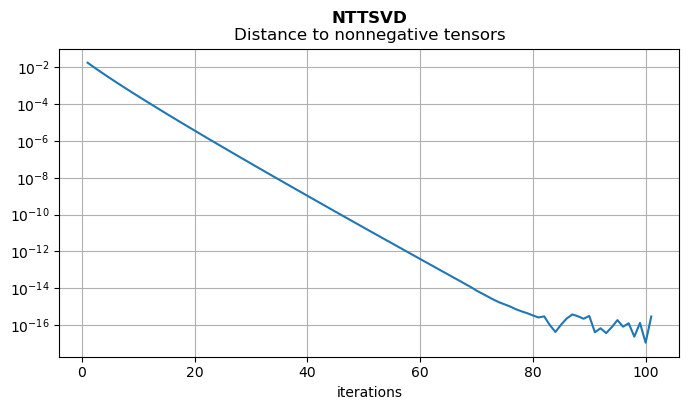

In [9]:
info.PlotNegativeElements()

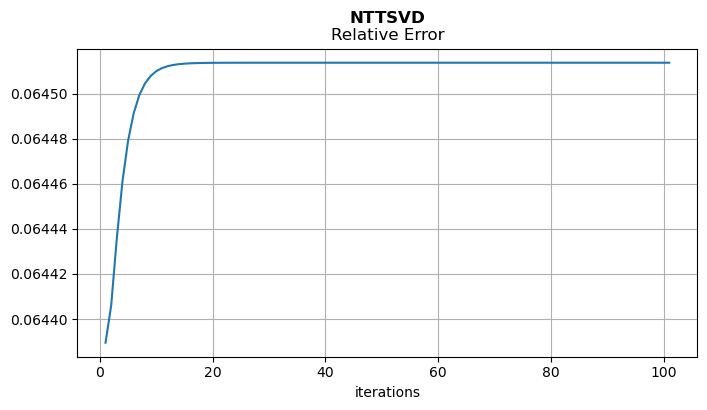

In [10]:
info.PlotErrors()

### 1.2 NTT

### 1.2.1 First step: tt + delta * minElement

In [11]:
# after TTSVD

full = TensorTrain.GetFullTensor(TensorTrain.TTSVD(a, ranks))
print('relative error', np.linalg.norm(a - full) / np.linalg.norm(a))
print('negative elements (frobenius):', np.linalg.norm(full[full < 0]))
print('negative elements (density):', (full < 0).sum() / np.prod(full.shape))
print('min element:', full.min())

relative error 0.06438947256049332
negative elements (frobenius): 0.017681386991018486
negative elements (density): 7.333333333333333e-05
min element: -0.008108665879828655


In [13]:
# for power method
itersNum1 = 50
itersNum2 = 800

###########
delta = 0.1
###########

info = Info(label='NTT')

# TTSVD
tt = TensorTrain(cores=TensorTrain.TTSVD(a, ranks).GetCores())
# searching for the minimum element of the tensor
minElement = tt.GetMinElement(alg='power', stage1=itersNum1, stage2=itersNum2, debug=True)
# correct the tensor elements
rank1Tensor = TensorTrain([np.ones((1, size, 1)) for size in tt._sizes])
rank1Tensor._cores[0] *= -minElement * delta
tt = tt + rank1Tensor
# print result
print()
info.ProcessTensorTrain(originalFullTensor=a, tt=tt)
info.PrintCurrentInfo()

maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.008108665879828655 / -0.007833185685305777

relative error: 0.07657946580601789
negative elements (frobenius): 0.015376874935548209
negative elements (chebyshev): 0.007325347311298078
negative elements (density): 7.333333333333333e-05


### 1.2.2 

In [14]:
# negative elements after TTSVD
full = TensorTrain.GetFullTensor(TensorTrain.TTSVD(a, ranks))
print('negative elements (frobenius):', np.linalg.norm(full[full < 0]))
print('negative elements (density):', (full < 0).sum() / np.prod(full.shape))
print('min element:', full.min())

negative elements (frobenius): 0.017681386991018486
negative elements (density): 7.333333333333333e-05
min element: -0.008108665879828655


In [42]:
stage1=100
stage2=500

itersNum=100

In [43]:
info = Info('NTT')
tt = TensorTrain.NTT(a, ranks=ranks, itersNum=itersNum, info=info, stage1=stage1, stage2=stage2, debug=True)

maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.008108665879828655 / -0.007574338961669147
minElement_(true/found): -0.008108665879828655 / -0.007589094391796225
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.007565951692335616 / -0.007039365590372104
minElement_(true/found): -0.007565951692335616 / -0.007055547386696004
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.006989668225415633 / -0.0064679111056271665
minElement_(true/found): -0.006989668225415633 / -0.006487113478403139
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.006377489195312048 / -0.0058563111711251725
minElement_(true/found): -0.006377489195312048 / -0.005881791630110933
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.005726889027772625 / -0.005191809200467912
minElement_(true/found): -0.005726

maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.00025099194787230354 / 0.0012692207321602922
minElement_(true/found): -0.00025099194787230354 / -2.5204257811273223e-05
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.00025099194787230354 / 0.0012739171538754812
minElement_(true/found): -0.00025099194787230354 / -2.264638420790277e-05
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.00025099194787230354 / 0.0012780491633520574
minElement_(true/found): -0.00025099194787230354 / -2.0384306514298345e-05
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.0002403524193028817 / 0.0012822898888008583
minElement_(true/found): -0.0002403524193028817 / -1.8103363961130547e-05
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765


KeyboardInterrupt: 

In [44]:
info.PrintCurrentInfo()

relative error: 0.0639776730419733
negative elements (frobenius): 0.0005230806161203646
negative elements (chebyshev): 0.0002403524193028817
negative elements (density): 7.333333333333333e-05


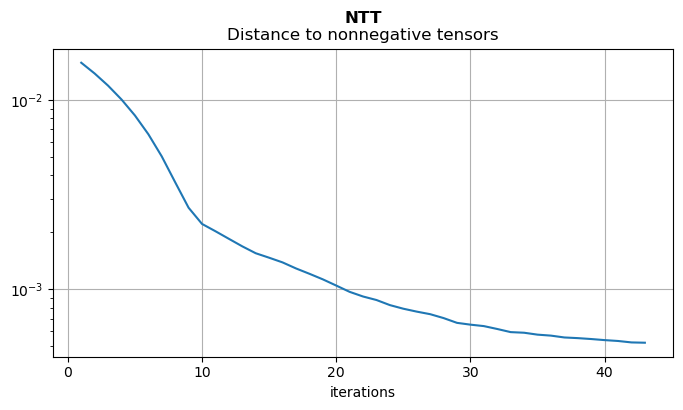

In [45]:
info.PlotNegativeElements()

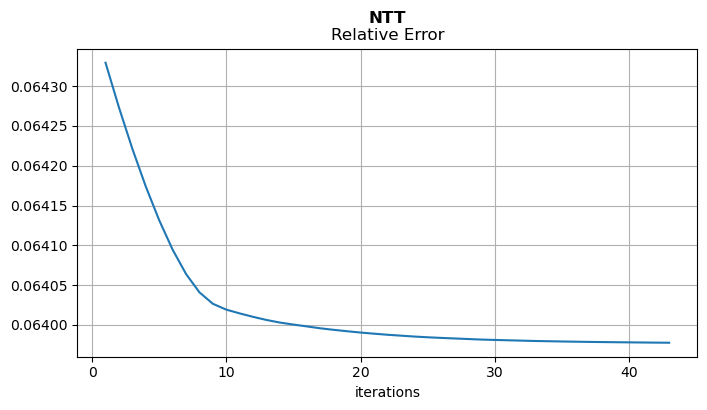

In [46]:
info.PlotErrors()

In [49]:
tt0 = tt
info0 = info

### 1.2.3 Correction at the end 

In [75]:
stage1=100
stage2=500

itersNum=10

In [76]:
info = Info('NTT')
tt = TensorTrain.NTT(a, ranks=ranks, itersNum=itersNum, info=info, stage1=stage1, stage2=stage2, debug=True)

maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.008108665879828655 / -0.007574338961669147
minElement_(true/found): -0.008108665879828655 / -0.007589094391796225
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.007565951692335616 / -0.007039365590372104
minElement_(true/found): -0.007565951692335616 / -0.007055547386696004
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.006989668225415633 / -0.0064679111056271665
minElement_(true/found): -0.006989668225415633 / -0.006487113478403139
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.006377489195312048 / -0.0058563111711251725
minElement_(true/found): -0.006377489195312048 / -0.005881791630110933
maxElement (true/found): 0.8250509163225765 / 0.8250509163225765
minElement (true/found): -0.005726889027772625 / -0.005191809200467912
minElement_(true/found): -0.005726

In [77]:
info.PrintCurrentInfo()

relative error: 0.0640192331928234
negative elements (frobenius): 0.0022163128246446132
negative elements (chebyshev): 0.0009712405066886732
negative elements (density): 7.333333333333333e-05


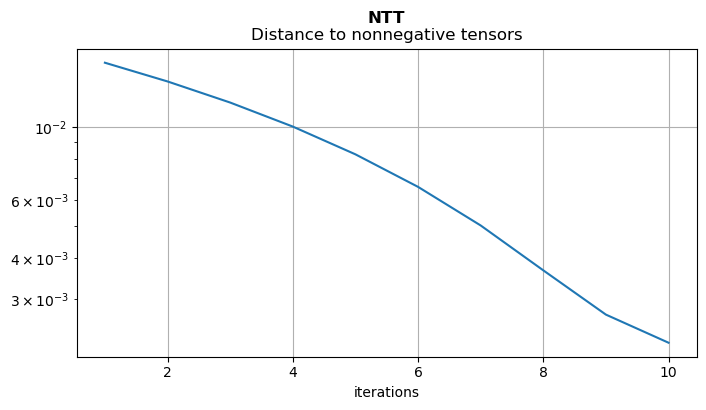

In [78]:
info.PlotNegativeElements()

In [79]:
tt0 = TensorTrain(cores=[core.copy() for core in tt.GetCores()])

In [170]:
minElement = -0.007833185685305777
################
delta = 0.123991
################

tt = TensorTrain(cores=[core.copy() for core in tt0.GetCores()])

rank1Tensor = TensorTrain([np.ones((1, size, 1)) for size in tt._sizes])
rank1Tensor._cores[0] *= -minElement * delta
tt = tt + rank1Tensor

info = Info()
info.ProcessTensorTrain(originalFullTensor=a, tt=tt)
info.PrintCurrentInfo()

relative error: 0.0824875601168966
negative elements (frobenius): 0.0
negative elements (chebyshev): 4.019618075456338e-09
negative elements (density): 0.0


In [171]:
t0 = time()
tt = TensorTrain.NTT(a, ranks=ranks, itersNum=itersNum, stage1=stage1, stage2=stage2)
print('time:', time() - t0, 's.')

info = Info('NTT')
info.ProcessTensorTrain(a, tt)
info.PrintCurrentInfo()

time: 40.692009925842285 s.
relative error: 0.0640192331928234
negative elements (frobenius): 0.0022163128246446132
negative elements (chebyshev): 0.0009712405066886732
negative elements (density): 7.333333333333333e-05
